# EDA — Synthetic Recommender Dataset (All Files)
This notebook analyzes **all** `train/*.parquet` and `test/*.parquet` under `data/`, plus user and restaurant features.
- Memory-friendly iteration: aggregates per-file statistics without loading everything at once.
- Global metrics: row counts, click rates, unique users/restaurants.
- Feature summaries: user/restaurant feature stats and correlations.
- Sampled feature–target analysis for interpretability.


In [1]:
import os, glob, math
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "data"
UF = os.path.join(DATA_DIR, "user_features.parquet")
RF = os.path.join(DATA_DIR, "restaurant_features.parquet")
TRAIN_GLOB = os.path.join(DATA_DIR, "train", "train_*.parquet")
TEST_GLOB  = os.path.join(DATA_DIR, "test", "test_*.parquet")

train_files = sorted(glob.glob(TRAIN_GLOB))
test_files  = sorted(glob.glob(TEST_GLOB))

print(f"Found {len(train_files)} train file(s) and {len(test_files)} test file(s).")

# Load feature tables (once)
user_features = pd.read_parquet(UF)
restaurant_features = pd.read_parquet(RF)

print("Users:", user_features.shape)
print("Restaurants:", restaurant_features.shape)

Found 80 train file(s) and 8 test file(s).
Users: (1000000, 31)
Restaurants: (100000, 13)


In [6]:
user_features.head(10)

,user_id,f00,f01,f02,f03,f04,f05,f06,f07,f08,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29
0,0,0.891713,1.410574,-0.070055,-0.014708,-1.201573,-0.076077,4.397160,1.879654,-0.642441,...,-0.658391,0.602271,2.106015,1.060264,-2.457296,0.301931,0.086897,-0.674744,-1.310826,3.419543
1,1,0.166255,-3.555174,-0.328230,1.227763,2.156429,3.370012,-3.126704,1.456747,2.425270,...,-1.898109,0.482804,-0.251568,1.929426,-1.788137,-0.397112,2.032990,1.077557,-2.776134,1.373556
2,2,-0.148486,-3.761515,2.627771,-0.150635,1.510427,-2.287910,2.624023,-1.287060,-0.172843,...,2.340453,1.479530,-3.487524,0.807051,2.835324,0.149990,-0.817896,0.609808,-1.109668,1.285083
3,3,-2.314206,-0.603777,1.033005,-0.578287,1.059556,-1.180098,-1.304305,-0.019504,-0.269193,...,-0.271788,-1.144094,1.930418,0.048006,0.795781,2.273345,2.239119,-0.647826,-1.048300,0.456213
4,4,3.477707,-0.930086,0.126100,0.752188,-1.671512,0.058350,0.053362,-3.419767,2.069209,...,3.381375,0.276913,-0.745553,3.906749,-0.287410,-3.045557,-0.816261,-4.585329,2.224948,-0.897116
5,5,-0.346317,-3.819631,2.352612,0.123555,1.631310,-2.319088,2.464272,-1.224456,-0.218752,...,2.567737,1.669098,-3.505077,0.774723,2.988309,0.136640,-1.091637,0.615993,-0.997816,1.401611
6,6,-0.075483,-3.541211,-0.355224,1.261535,2.105481,3.459506,-3.005603,1.465072,2.486498,...,-1.774632,0.360583,-0.109967,2.018467,-1.841285,-0.231643,2.008739,0.974777,-2.845712,1.215662
7,7,-0.802110,-1.803191,1.246563,0.297520,-0.242320,1.444788,1.009463,0.703140,1.987661,...,-1.417273,1.129047,-1.257939,-2.330181,-2.321569,-1.110784,-0.576369,-1.618727,-0.708921,-3.115804
8,8,3.520841,-1.071891,0.164355,0.747264,-1.499215,0.125200,0.035645,-3.358571,1.901129,...,3.153112,0.095017,-0.884477,3.998364,-0.106575,-2.700280,-1.139569,-4.576940,2.089204,-0.897207
9,9,-0.805406,-1.745193,1.370718,0.239294,-0.198126,1.485986,1.017657,0.677018,2.022162,...,-1.427840,0.774536,-1.115961,-2.094461,-2.477725,-1.163101,-0.442785,-1.738047,-0.646466,-3.174242


In [7]:
restaurant_features.head(10)

,restaurant_id,latitude,longitude,f00,f01,f02,f03,f04,f05,f06,f07,f08,f09
0,0,13.695629,100.782473,1.548033,0.831106,-1.238846,-1.776407,-1.424001,1.027612,1.996351,1.724807,0.308744,-1.288446
1,1,13.871313,100.567492,-1.625050,1.729912,0.045959,0.616558,-1.835436,3.392681,1.419157,-2.359236,1.552935,-0.636819
2,2,13.800272,100.673238,4.242981,0.635197,3.358177,5.178564,1.642555,2.865949,1.256047,0.317113,-0.972126,-4.699697
3,3,14.165760,100.309979,-1.709498,1.645328,-0.104129,0.575438,-2.055411,3.399226,1.464834,-2.377462,1.662965,-0.574166
4,4,13.717938,100.339823,4.410061,0.754958,3.260095,5.312267,1.372185,2.875425,1.206356,0.548530,-0.924070,-4.836117
5,5,13.784802,100.695145,1.003301,-0.174433,0.012206,1.579504,2.884146,0.679871,5.162926,0.596967,1.033260,-0.337527
6,6,13.865481,100.679902,-0.448528,-1.752278,2.468978,1.381796,2.110785,-0.224763,-0.125767,-0.223134,-0.548016,-3.666602
7,7,13.794270,100.607648,-0.328988,-1.765682,2.720564,1.242162,2.021470,-0.126060,-0.282208,-0.010721,-0.425123,-3.758349
8,8,14.095324,100.823114,-0.365276,-1.603673,2.744319,1.321989,2.145040,-0.049027,-0.207522,-0.229593,-0.364173,-3.550317
9,9,14.019035,100.451150,3.399298,-1.397825,-2.162741,-0.083074,0.711825,-1.460670,-0.425206,1.857794,-0.558791,-0.243648


In [9]:
pd.read_parquet(train_files[0]).head(10)

,user_id,restaurant_id,click
0,982159,42457,1
1,325309,41013,1
2,142982,74388,1
3,315958,615,0
4,291320,31327,1
5,984158,24098,1
6,187354,47586,1
7,799609,51493,1
8,924374,77485,0
9,26995,71357,0


In [15]:
df = pd.read_parquet(train_files[0])
df[df["user_id"]==982159]

,user_id,restaurant_id,click
0,982159,42457,1
368905,982159,11352,0


In [2]:
# ---- Aggregate Train/Test Click Stats Across All Files ----
def aggregate_clicks(files):
    total_rows = 0
    total_pos = 0
    user_set = set()
    rest_set = set()
    per_file = []
    # optional heavy: per-entity counts
    user_counts = Counter()
    rest_counts = Counter()

    for f in files:
        df = pd.read_parquet(f, columns=["user_id", "restaurant_id", "click"])
        n = len(df)
        p = int(df["click"].sum())
        total_rows += n
        total_pos += p
        # uniques
        user_set.update(df["user_id"].unique())
        rest_set.update(df["restaurant_id"].unique())
        # counts (can be commented out if too slow)
        user_counts.update(df["user_id"].value_counts().to_dict())
        rest_counts.update(df["restaurant_id"].value_counts().to_dict())

        per_file.append({
            "file": os.path.basename(f),
            "rows": n,
            "pos": p,
            "click_rate": (p / n) if n else float("nan"),
        })
    overall_click_rate = (total_pos / total_rows) if total_rows else float("nan")
    return {
        "total_rows": total_rows,
        "total_pos": total_pos,
        "overall_click_rate": overall_click_rate,
        "unique_users": len(user_set),
        "unique_restaurants": len(rest_set),
        "per_file": pd.DataFrame(per_file).sort_values("file").reset_index(drop=True),
        "user_counts": user_counts,
        "rest_counts": rest_counts,
    }

train_agg = aggregate_clicks(train_files)
test_agg  = aggregate_clicks(test_files)

print("Train rows:", train_agg["total_rows"], "  clicks:", train_agg["total_pos"], "  click_rate:", round(train_agg["overall_click_rate"], 4))
print("Test  rows:", test_agg["total_rows"],  "  clicks:", test_agg["total_pos"],  "  click_rate:", round(test_agg["overall_click_rate"], 4))

print("Unique users (train):", train_agg["unique_users"], "  Unique restaurants (train):", train_agg["unique_restaurants"])
print("Unique users (test):",  test_agg["unique_users"],  "  Unique restaurants (test):",  test_agg["unique_restaurants"])

# Save per-file stats
out_dir = DATA_DIR
train_agg["per_file"].to_csv(os.path.join(out_dir, "eda_train_file_stats.csv"), index=False)
test_agg["per_file"].to_csv(os.path.join(out_dir, "eda_test_file_stats.csv"), index=False)
print("Saved per-file stats to data/eda_train_file_stats.csv and data/eda_test_file_stats.csv")

Train rows: 50000000   clicks: 23095119   click_rate: 0.4619
Test  rows: 5000000   clicks: 2311792   click_rate: 0.4624
Unique users (train): 1000000   Unique restaurants (train): 100000
Unique users (test): 993201   Unique restaurants (test): 100000
Saved per-file stats to data/eda_train_file_stats.csv and data/eda_test_file_stats.csv


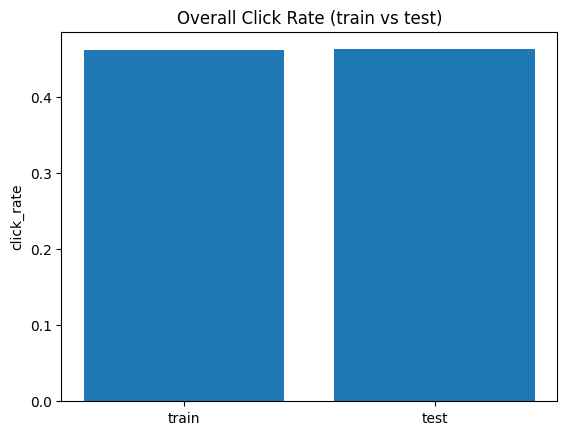

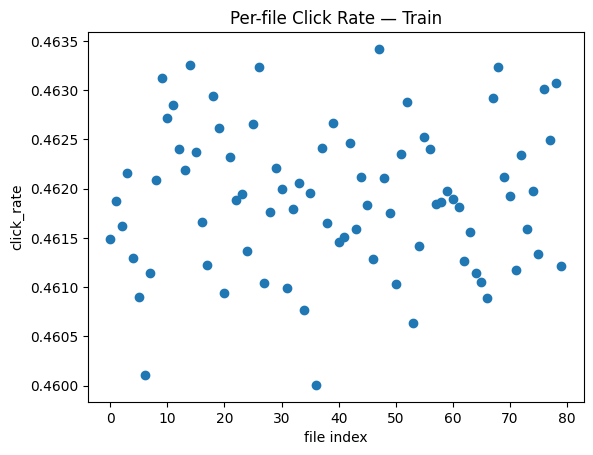

In [3]:
# ---- Visuals: Overall Click Rates and Per-file Distribution ----
plt.figure()
x = ["train", "test"]
y = [train_agg["overall_click_rate"], test_agg["overall_click_rate"]]
plt.bar(x, y)
plt.title("Overall Click Rate (train vs test)")
plt.ylabel("click_rate")
plt.show()

plt.figure()
series = train_agg["per_file"]["click_rate"]
plt.plot(range(len(series)), series.values, marker="o", linestyle="")
plt.title("Per-file Click Rate — Train")
plt.xlabel("file index")
plt.ylabel("click_rate")
plt.show()

,mean,std,min,max
f00,-0.202621,1.477980,-2.740567,3.800561
f01,-0.739928,2.353302,-4.300187,3.194374
f02,0.276454,1.460829,-3.732014,2.963172
f03,0.721641,1.366956,-1.885141,3.842165
f04,-0.191619,1.762537,-4.570313,2.611989
f05,-0.355360,2.050732,-4.121038,3.869313
f06,-0.490654,2.389516,-3.537963,4.964104
f07,0.081103,1.881650,-3.937813,3.336745
f08,0.288749,2.190503,-5.047843,3.955872
f09,0.223883,1.726860,-3.233983,2.712128


,mean,std,min,max
f00,1.006124,1.873138,-1.944015,4.740159
f01,0.381235,1.883118,-2.445729,4.787621
f02,0.368885,1.943542,-2.834371,3.584698
f03,0.498739,2.174275,-3.420848,5.712517
f04,-0.435555,2.022462,-3.703248,3.175956
f05,-0.267531,2.573393,-6.040717,3.641565
f06,0.983398,2.291201,-2.545392,5.509756
f07,0.004655,1.298291,-2.579199,2.218144
f08,-0.180083,1.013497,-2.071345,2.057308
f09,-1.196845,1.686557,-5.227576,1.088450


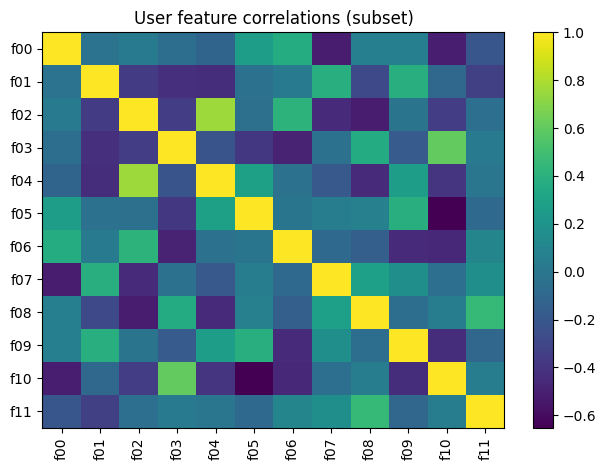

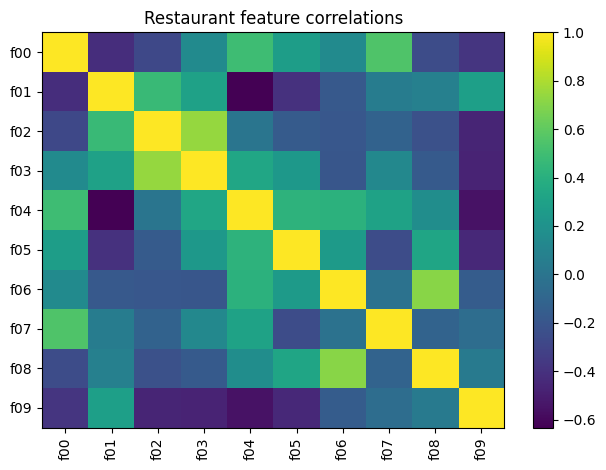

In [4]:
# ---- Feature Summaries ----
# User features f00..f29, Restaurant features f00..f09
uf_cols = [f"f{i:02d}" for i in range(30)]
rf_cols = [f"f{i:02d}" for i in range(10)]

uf_stats = user_features[uf_cols].describe().T[['mean','std','min','max']]
rf_stats = restaurant_features[rf_cols].describe().T[['mean','std','min','max']]
display(uf_stats.head(10))
display(rf_stats.head(10))

# Correlations (subset to keep plot legible)
uf_corr = user_features[uf_cols[:12]].corr()
rf_corr = restaurant_features[rf_cols].corr()

plt.figure()
plt.imshow(uf_corr.values, aspect='auto')
plt.xticks(range(uf_corr.shape[1]), uf_corr.columns, rotation=90)
plt.yticks(range(uf_corr.shape[0]), uf_corr.index)
plt.title("User feature correlations (subset)")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(rf_corr.values, aspect='auto')
plt.xticks(range(rf_corr.shape[1]), rf_corr.columns, rotation=90)
plt.yticks(range(rf_corr.shape[0]), rf_corr.index)
plt.title("Restaurant feature correlations")
plt.colorbar()
plt.tight_layout()
plt.show()

Merged sample shape: (100000, 45)


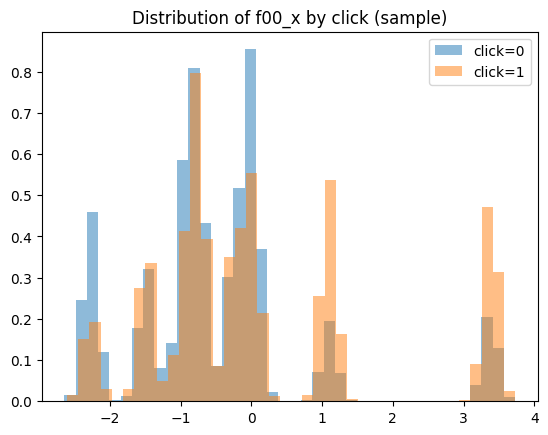

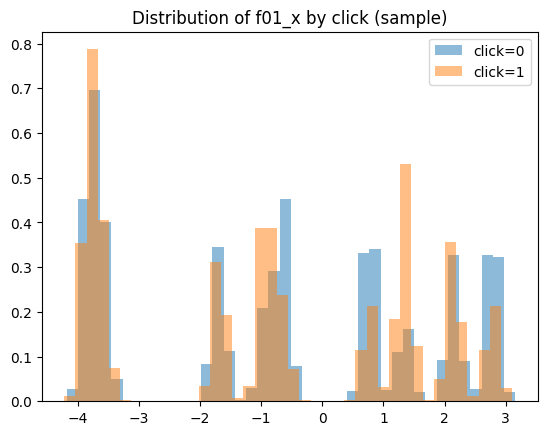

In [21]:
# ---- Sampled Feature–Target Analysis ----
# Sample up to N rows across all train shards to merge with features for inspection
N = 100_000
samples = []
remaining = N
for f in train_files:
    if remaining <= 0:
        break
    df = pd.read_parquet(f, columns=["user_id", "restaurant_id", "click"])
    take = min(len(df), max(2000, int(N / max(1, len(train_files)))))  # balanced sampling
    samples.append(df.sample(n=take, random_state=42) if len(df) > take else df)
    remaining -= take

if samples:
    merged = (pd.concat(samples, ignore_index=True)
              .merge(user_features, on="user_id", how="left")
              .merge(restaurant_features, on="restaurant_id", how="left"))
    print("Merged sample shape:", merged.shape)

    # Distribution of a couple of example features by click
    for col in ["f00_x", "f01_x"]:
        plt.figure()
        for label, grp in merged.groupby("click"):
            # simple histogram overlay (no specific colors)
            vals = grp[col].dropna().values
            # use same bins for comparability
            bins = 40
            plt.hist(vals, bins=bins, alpha=0.5, label=f"click={int(label)}", density=True)
        plt.title(f"Distribution of {col} by click (sample)")
        plt.legend()
        plt.show()
else:
    print("No train samples available to merge for feature–target plots.")

In [22]:
# ---- Save Global Summary ----
summary = {
    "n_train_files": len(train_files),
    "n_test_files": len(test_files),
    "train_rows": train_agg["total_rows"],
    "train_clicks": int(train_agg["total_pos"]),
    "train_click_rate": float(train_agg["overall_click_rate"]),
    "test_rows": test_agg["total_rows"],
    "test_clicks": int(test_agg["total_pos"]),
    "test_click_rate": float(test_agg["overall_click_rate"]),
    "unique_users_train": int(train_agg["unique_users"]),
    "unique_restaurants_train": int(train_agg["unique_restaurants"]),
    "unique_users_test": int(test_agg["unique_users"]),
    "unique_restaurants_test": int(test_agg["unique_restaurants"]),
}

pd.Series(summary).to_csv(os.path.join(DATA_DIR, "eda_summary_all.csv"))
print("Saved data/eda_summary_all.csv")

Saved data/eda_summary_all.csv
